In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [86]:
data = pd.read_csv('C:\\Users\\Mell\\Desktop\\Рекомендательные системы\\webinar_2\\retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [87]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - что это за товар?  
**Не самые популярные товары - товары которые не попали в ТОП 5000.**  
Зачем он нужен?  
**Он нужен затем, чтобы мы не потеряли юзеров, которые не покупали товары из ТОПа и, чтобы такие юзеры попали в выборку**  
Используя этот товар мы смещаем качество рекомендаций.
В какую сторону?
**Т.к. такой товар часто оказывается не первом месте в списке рекомендаций и при этом является фиктивным, то он отчасти ухудшает качетсво рекомендаций**   
Можно ли удалить этот товар?  
**Этот товар не стоит удалять, т.к. большое количество юзеров не попадет в обучающую выборку**  
Уберите этот товар и сравните с качеством на семинаре.

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. вес = log(sales_sum товара)
- Придумайте пример 3 весов, посчитайте weighted_random_recommendation для разных весов

In [88]:
items_weights = data_train.groupby(by='item_id')['sales_value'].sum().reset_index().rename(columns={'sales_value':'weight'})

In [89]:
items_weights['weight'] += 1
items_weights['weight'] = np.log(items_weights['weight'])
items_weights['weight'] /= items_weights['weight'].sum()
items_weights['weight'].sum()

1.0

In [90]:
def weighted_random_recommendation(items_weights, n=5):
    items = np.array(items_weights['item_id'])
    recs = np.random.choice(items, size=n, replace=False, p=items_weights['weight'])
    return recs.tolist()

Сделайте предсказания

In [91]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [92]:
%%time
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

Wall time: 1.96 s


In [93]:
result.head(3)

,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[864312, 12301475, 1029894, 10150004, 983000]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082141, 949766, 1016889, 935342, 8069055]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[6464150, 1137824, 1012051, 12605527, 690927]"


In [94]:
result_weighted_random = result.copy()

In [95]:
result_weighted_random.drop(['actual'], axis='columns', inplace=True)

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма (с вебинара и weighted_random_recommendation) с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество? Почему?

In [111]:
result_w = pd.read_csv('C:\\Users\\Mell\\Desktop\\Рекомендательные системы\\webinar_2\\preds.csv')# закгрузка predict с семианара
result_w.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12301743, 1197499, 13158155, 12777288, 1090812]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[926554, 596117, 6551663, 2072973, 929091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [112]:
result_wb = pd.merge(result_w, result_weighted_random, how ='inner', on ='user_id')

In [113]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    print(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [ ]:
result_wb['actual'] = result_wb['actual'].map(lambda x: x[1:-1].split(', ')).apply(lambda x: list(map(int, x)))
metric = pd.DataFrame(index=['precision@5'])

for i in result_wb.columns[2:]:
    if i != 'weighted_random_recommendation':
        result_wb[i] = result_wb[i].map(lambda x: x[1:-1].split(', ')).apply(lambda x: list(map(int, x)))
    res = result_wb.apply(lambda x: precision_at_k(x[i], x['actual'],  5), axis=1)
    metric[i] = res.mean();

In [116]:
metric

,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
precision@5,0.00049,0.15524,0.136925,0.132909,0.138981,0.179693,0.000881


**own_purchases** (Трюк) покказал лучший результат.

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
- Попробуйте стратегии ансамблирования изученных алгоритмов


In [117]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [118]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
items = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

result_wb['random_recommendation_5000'] = result_wb['user_id'].apply(lambda x: random_recommendation(items, n=5))

In [ ]:
res = result_wb.apply(lambda x: precision_at_k(x['random_recommendation_5000'], x['actual'],  5), axis=1)
metric['random_recommendation_5000'] = res.mean();

In [122]:
metric[['random_recommendation','random_recommendation_5000']]

,random_recommendation,random_recommendation_5000
precision@5,0.00049,0.005583


**Использование топ-5000 товаров улучшило бейзлайн**

Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей  𝐾 .

In [125]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [126]:
import warnings
warnings.filterwarnings('ignore')

In [173]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [174]:
result_test = result_wb[['user_id','actual']]

In [175]:
k_list = np.arange(1, 100, 2)

In [ ]:
%%time
for k in k_list:
    model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                            user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                            N=5, # кол-во рекомендаций 
                            filter_already_liked_items=False, 
                            filter_items=None, 
                            recalculate_user=True)
    
    result_test[f'itemitem_{k}'] = result_test['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])

In [ ]:
metric_test = pd.DataFrame(index=['precision@5'])

for i in result_test.columns[2:]:
    res = result_test.apply(lambda x: precision_at_k(x[i], x['actual'],  5), axis=1)
    metric_test[i] = res.mean();

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

0.1860920666013684

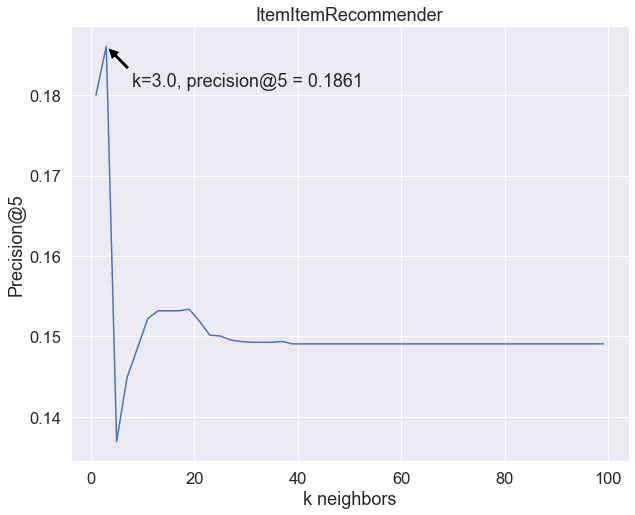

In [224]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
line, = ax.plot(list(k_list),metric_test.T)

ymax = max(metric_test.T['precision@5'])
xmax = float(max(metric_test.T.idxmax()).split('_')[1])

ax.annotate(f'k={xmax}, precision@5 = {round(ymax,4)}', xy=(xmax, ymax), xytext=(xmax+5, ymax-0.005),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.xlabel('k neighbors')
plt.ylabel('Precision@5')
plt.title('ItemItemRecommender')
plt.show()

**Как видно, оптимальным количеством соседей будет 3. При изменении числа соседей от 3 до 20 происходит изменение метрики, после чего метрика становится константой.**

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.